In [1]:
import cenpy
import contextily as ctx 
import segregation
%matplotlib inline
import matplotlib as mpl

In [2]:
import xyzservices.providers as xyz
import matplotlib.pyplot as plt #to make sure there are no errors when plotting a graph
from contextily import add_basemap
import folium 

In [3]:
import geopandas as gpd 
from census import Census 
from us import states
from shapely.geometry import Polygon

In [4]:
import pandas as pd

In [142]:
from contextily import Place


**Census Api**

In [5]:
acs=cenpy.products.ACS(year="latest")  
acs.filter_tables('HOUSEHOLDER', by='description')


,description,columns
table_name,,
B09005,HOUSEHOLD TYPE FOR CHILDREN UNDER 18 YEARS IN ...,"[B09005_001E, B09005_002E, B09005_003E, B09005..."
B09018,RELATIONSHIP TO HOUSEHOLDER FOR CHILDREN UNDER...,"[B09018_001E, B09018_002E, B09018_003E, B09018..."
B10001,GRANDCHILDREN UNDER 18 YEARS LIVING WITH A GRA...,"[B10001_001E, B10001_002E, B10001_003E, B10001..."
B10002,GRANDCHILDREN UNDER 18 YEARS LIVING WITH A GRA...,"[B10002_001E, B10002_002E, B10002_003E, B10002..."
B10010,MEDIAN FAMILY INCOME FOR FAMILIES WITH GRANDPA...,"[B10010_001E, B10010_002E, B10010_003E]"
B11010,NONFAMILY HOUSEHOLDS BY SEX OF HOUSEHOLDER BY ...,"[B11010_001E, B11010_002E, B11010_003E, B11010..."
B17009,POVERTY STATUS BY WORK EXPERIENCE OF UNRELATED...,"[B17009_001E, B17009_002E, B17009_003E, B17009..."
B17016,POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILI...,"[B17016_001E, B17016_002E, B17016_003E, B17016..."
B17017,POVERTY STATUS IN THE PAST 12 MONTHS BY HOUSEH...,"[B17017_001E, B17017_002E, B17017_003E, B17017..."


In [6]:
c = Census('f5e7cf46eaa83ae8323e6051f74d9ab363d0b957')

In [7]:
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
bxr_householder_by_race = c.acs5.state_county_tract(fields = ('NAME', 'B25006_001E', 'B25006_002E', 'B25006_003E'),
                                      state_fips = states.TX.fips, 
                                      county_fips = "029",
                                      tract = "*",
                                      year = 2019)

In [8]:
bxr_hh_race_df = pd.DataFrame(bxr_householder_by_race)

In [9]:
print(bxr_hh_race_df.head(2))
print('Shape: ', bxr_hh_race_df.shape)

                                     NAME  B25006_001E  B25006_002E  \
0  Census Tract 1109, Bexar County, Texas       1016.0        891.0   
1  Census Tract 1110, Bexar County, Texas       1188.0        776.0   

   B25006_003E state county   tract  
0         30.0    48    029  110900  
1        103.0    48    029  111000  
Shape:  (366, 7)


access shapefile of bexar county. this will coordinate data and alignment with Mercator projection

In [10]:
bxr_census_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_48_tract.zip")

print(bxr_census_tract)

     STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  \
0         48      439  121609  48439121609  1216.09  Census Tract 1216.09   
1         48      187  210708  48187210708  2107.08  Census Tract 2107.08   
2         48      201  550301  48201550301  5503.01  Census Tract 5503.01   
3         48      201  550302  48201550302  5503.02  Census Tract 5503.02   
4         48      157  675800  48157675800     6758     Census Tract 6758   
...      ...      ...     ...          ...      ...                   ...   
5260      48      167  720501  48167720501  7205.01  Census Tract 7205.01   
5261      48      167  721202  48167721202  7212.02  Census Tract 7212.02   
5262      48      167  722002  48167722002  7220.02  Census Tract 7220.02   
5263      48      167  720301  48167720301  7203.01  Census Tract 7203.01   
5264      48      167  720503  48167720503  7205.03  Census Tract 7205.03   

      MTFCC FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON  \
0   

In [11]:
print(bxr_census_tract.head(2))

print('Shape: ', bxr_census_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(bxr_census_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  MTFCC  \
0      48      439  121609  48439121609  1216.09  Census Tract 1216.09  G5020   
1      48      187  210708  48187210708  2107.08  Census Tract 2107.08  G5020   

  FUNCSTAT    ALAND   AWATER     INTPTLAT      INTPTLON  \
0        S  4036421  2474977  +32.6893777  -097.2140987   
1        S  2625635        0  +29.5747421  -098.2516707   

                                            geometry  
0  POLYGON ((-97.23369 32.67175, -97.23366 32.671...  
1  POLYGON ((-98.26254 29.57872, -98.26236 29.578...  
Shape:  (5265, 13)

The shapefile projection is: epsg:4269


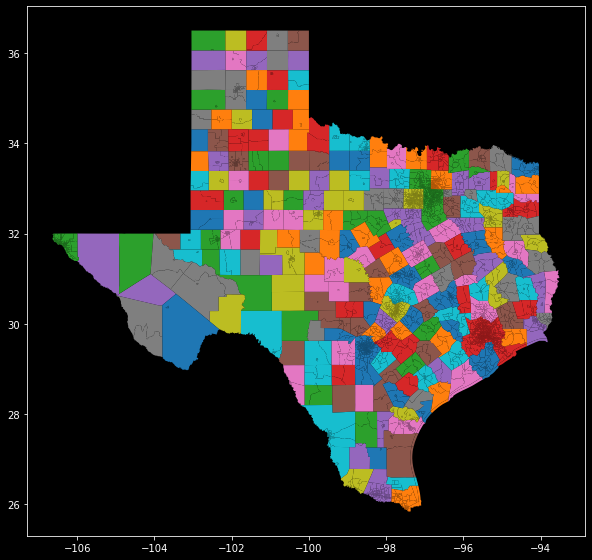

In [22]:
bxr_census_tract.plot('COUNTYFP', legend=False, figsize=(10,10))

plt.style.use('dark_background')



performing dataframe operations= https://pygis.io/docs/e_vector_merge_dissolve.html

In [30]:
# Combine state, county, and tract columns together to create a new string and assign to new column
bxr_hh_race_df["GEOID"] = bxr_hh_race_df["state"] + bxr_hh_race_df["county"] + bxr_hh_race_df["tract"]

In [31]:
bxr_hh_race_df.head(2)

,NAME,B25006_001E,B25006_002E,B25006_003E,state,county,tract,pct_householders,GEOID
0,"Census Tract 1109, Bexar County, Texas",1016.0,891.0,30.0,48,029,110900,2.952756,48029110900
1,"Census Tract 1110, Bexar County, Texas",1188.0,776.0,103.0,48,029,111000,8.670034,48029111000


In [32]:
# Remove columns
bxr_hh_race_df = bxr_hh_race_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
bxr_hh_race_df.head(2)

,NAME,B25006_001E,B25006_002E,B25006_003E,pct_householders,GEOID
0,"Census Tract 1109, Bexar County, Texas",1016.0,891.0,30.0,2.952756,48029110900
1,"Census Tract 1110, Bexar County, Texas",1188.0,776.0,103.0,8.670034,48029111000


check column data types 

In [33]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(bxr_hh_race_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(bxr_census_tract.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html

Column data types for census data:
NAME                 object
B25006_001E         float64
B25006_002E         float64
B25006_003E         float64
pct_householders    float64
GEOID                object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


merge dataframes

In [34]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
bxr_merge = bxr_census_tract.merge(bxr_hh_race_df, on = "GEOID")

# Show result
print(bxr_merge.head(2))
print('Shape: ', bxr_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID NAME_x           NAMELSAD  MTFCC  \
0      48      029  121000  48029121000   1210  Census Tract 1210  G5020   
1      48      029  161400  48029161400   1614  Census Tract 1614  G5020   

  FUNCSTAT     ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S   6640253   33515  +29.5322204  -098.4454653   
1        S  11020658       0  +29.3866196  -098.6178562   

                                            geometry  \
0  POLYGON ((-98.46917 29.51845, -98.46904 29.518...   
1  POLYGON ((-98.64202 29.39557, -98.64202 29.395...   

                                   NAME_y  B25006_001E  B25006_002E  \
0  Census Tract 1210, Bexar County, Texas       2616.0       2291.0   
1  Census Tract 1614, Bexar County, Texas        413.0        274.0   

   B25006_003E  pct_householders  
0        136.0          5.198777  
1         79.0         19.128329  
Shape:  (366, 18)


Subset dataframe. working with bxr_merge shapefile

In [60]:
# Create new dataframe from select columns
bxr_hh_race_tract = bxr_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "B25006_001E", "B25006_003E"]]

# Show dataframe
print(bxr_hh_race_tract.head(2))
print('Shape: ', bxr_hh_race_tract.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      48      029  121000  48029121000   
1      48      029  161400  48029161400   

                                            geometry  B25006_001E  B25006_003E  
0  POLYGON ((-98.46917 29.51845, -98.46904 29.518...       2616.0        136.0  
1  POLYGON ((-98.64202 29.39557, -98.64202 29.395...        413.0         79.0  
Shape:  (366, 7)


In [61]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
bxr_hh_race_county = bxr_hh_race_tract.dissolve(by = 'TRACTCE', aggfunc = 'sum')

# Show dataframe
print(bxr_hh_race_county.head())
print('Shape: ', bxr_hh_race_county.shape)

                                                  geometry  B25006_001E  \
TRACTCE                                                                   
110100   POLYGON ((-98.50150 29.43284, -98.50141 29.432...       1786.0   
110300   POLYGON ((-98.48951 29.41564, -98.48907 29.415...       1411.0   
110500   POLYGON ((-98.51493 29.41416, -98.51486 29.414...        786.0   
110600   POLYGON ((-98.51382 29.42267, -98.51381 29.422...       1305.0   
110700   POLYGON ((-98.51508 29.44412, -98.51496 29.444...        554.0   

         B25006_003E  
TRACTCE               
110100          17.0  
110300          58.0  
110500          39.0  
110600          69.0  
110700          33.0  
Shape:  (366, 3)


In [302]:
# Get householder by race rate and store values in new column
bxr_hh_race_county["pct_householders"] = (bxr_hh_race_county["B25006_003E"]) * 100


# Show dataframe
bxr_hh_race_county.head(10)  

,geometry,B25006_001E,B25006_003E,pct_householders
TRACTCE,,,,
110100,"POLYGON ((-98.50150 29.43284, -98.50141 29.432...",1786.0,17.0,1700.0
110300,"POLYGON ((-98.48951 29.41564, -98.48907 29.415...",1411.0,58.0,5800.0
110500,"POLYGON ((-98.51493 29.41416, -98.51486 29.414...",786.0,39.0,3900.0
110600,"POLYGON ((-98.51382 29.42267, -98.51381 29.422...",1305.0,69.0,6900.0
110700,"POLYGON ((-98.51508 29.44412, -98.51496 29.444...",554.0,33.0,3300.0
110800,"POLYGON ((-98.49936 29.44703, -98.49836 29.447...",860.0,55.0,5500.0
110900,"POLYGON ((-98.48973 29.43855, -98.48874 29.439...",1016.0,30.0,3000.0
111000,"POLYGON ((-98.48010 29.43690, -98.47996 29.437...",1188.0,103.0,10300.0
120100,"POLYGON ((-98.47386 29.44534, -98.47362 29.445...",922.0,196.0,19600.0


In [303]:
bxr_hh_race_county_basemap, bxr_hh_race_county_extent = ctx.bounds2img(*bxr_hh_race_county.total_bounds, zoom=10,   
                                            source=ctx.providers.OpenStreetMap.Mapnik)

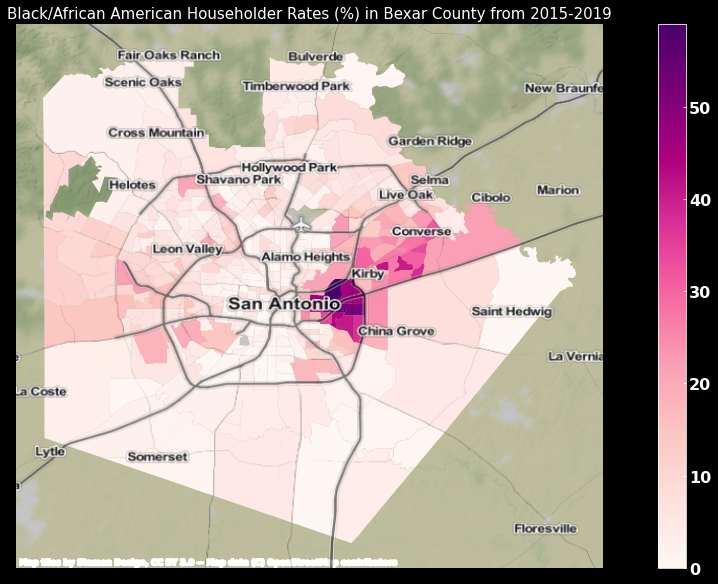

In [307]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html

bxr_plot = bxr_merge.plot('pct_householders', 
                       ax = ax,
                       cmap = 'RdPu',
                       legend = True,
                                      )

ctx.Place("San Antonio, Tx")

ctx.add_basemap(ax, crs=4269, source=ctx.providers.Stamen.TonerLines, alpha=.5)
ctx.add_basemap(ax, crs=4269, source=ctx.providers.Stamen.TerrainBackground, alpha=.85)
ctx.add_basemap(ax, crs=4269, source=ctx.providers.Stamen.TonerLabels, alpha=.90, zoom=10)
ax.set_axis_off()

# Stylize plots
plt.style.use('dark_background')


ax.grid(visible=None) #remove grid lines 

# Set title
ax.set_title('Black/African American Householder Rates (%) in Bexar County from 2015-2019', fontdict = {'fontsize': '15', 'fontweight' : '3'})

ax.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

In [124]:
bxr_merge.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich